# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,14)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from model import LeastSquaresMixture
from math import floor

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [2]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split(threshold=0.7)

Loading data set...
Data loaded.


## Data processing

In [7]:
#N = 16000
#N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 975
n_samples = 1
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)
samples = t1 - 1

#N_projects = sk.choose_n_projects(n=N, seed=seed)
#projects_train = N_projects[:N_train]
#projects_test = N_projects[N_train:]

# Remove outliers
outlier_threshold = 10  # Ignore the project whose total pledged money if more that o_t times their goal
projects_train_filtered = [p for p in projects_train if p.money[T] < outlier_threshold and p.project_id != "564047599"]

X_train = np.ndarray(shape=(len(projects_train_filtered), t), buffer=np.array([p.money[samples] for p in projects_train_filtered]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test), t), buffer=np.array([p.money[samples] for p in projects_test]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
#X_max = np.max(X_train, axis=0)
#X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
#X_test = X_test / X_max[np.newaxis, :]  

print("Training on %s projects" % len(X_train))
print("Testing on %s projects" % len(X_test))
print("Number of features: %s" % n_samples)

Training on 11123 projects
Testing on 4813 projects
Number of features: 1


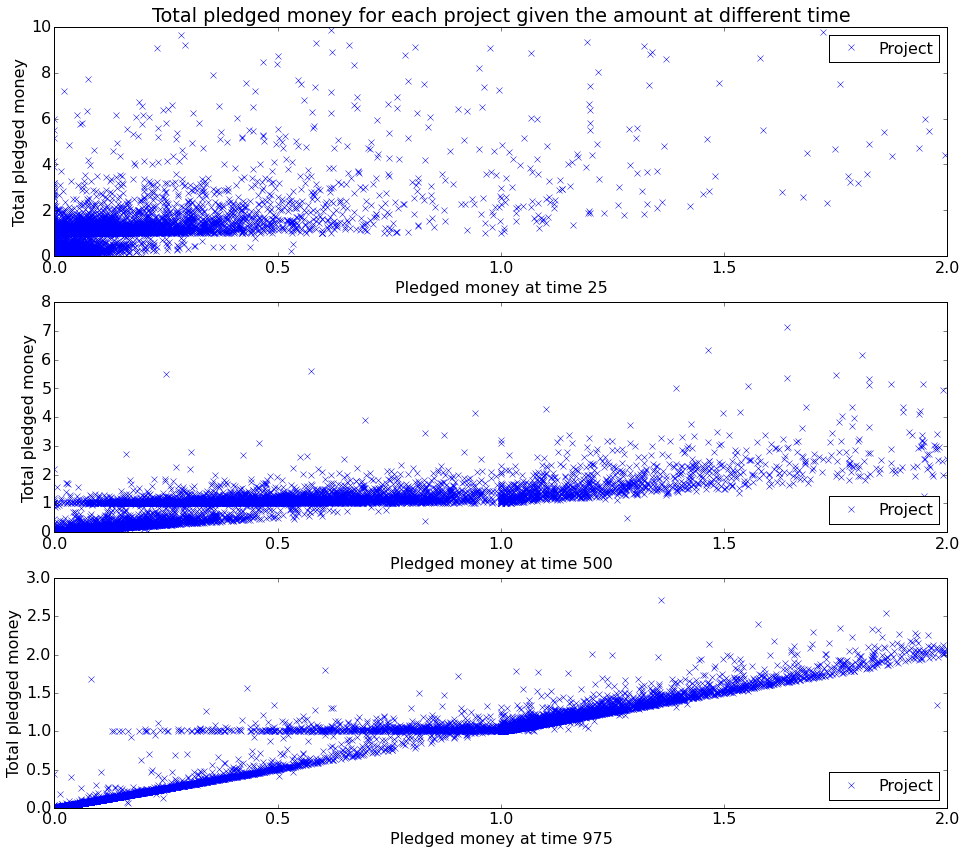

In [8]:
T = 999

plt.figure(2)

plt.subplot(311)
t = 25
yt = [p.money[t] for p in projects_train if p.money[T] < 10 and p.money[t] < 2]
yT = [p.money[T] for p in projects_train if p.money[T] < 10 and p.money[t] < 2]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=1, numpoints=1)
plt.title('Total pledged money for each project given the amount at different time')

plt.subplot(312)
t = 500
yt = [p.money[t] for p in projects_train if p.money[T] < 10 and p.money[t] < 2]
yT = [p.money[T] for p in projects_train if p.money[T] < 10 and p.money[t] < 2]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)

plt.subplot(313)
t = 975
yt = [p.money[t] for p in projects_train if p.money[T] < 10 and p.money[t] < 2]
yT = [p.money[T] for p in projects_train if p.money[T] < 10 and p.money[t] < 2]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)


plt.savefig('final_money_vs_pledged_money.pdf')
plt.show()

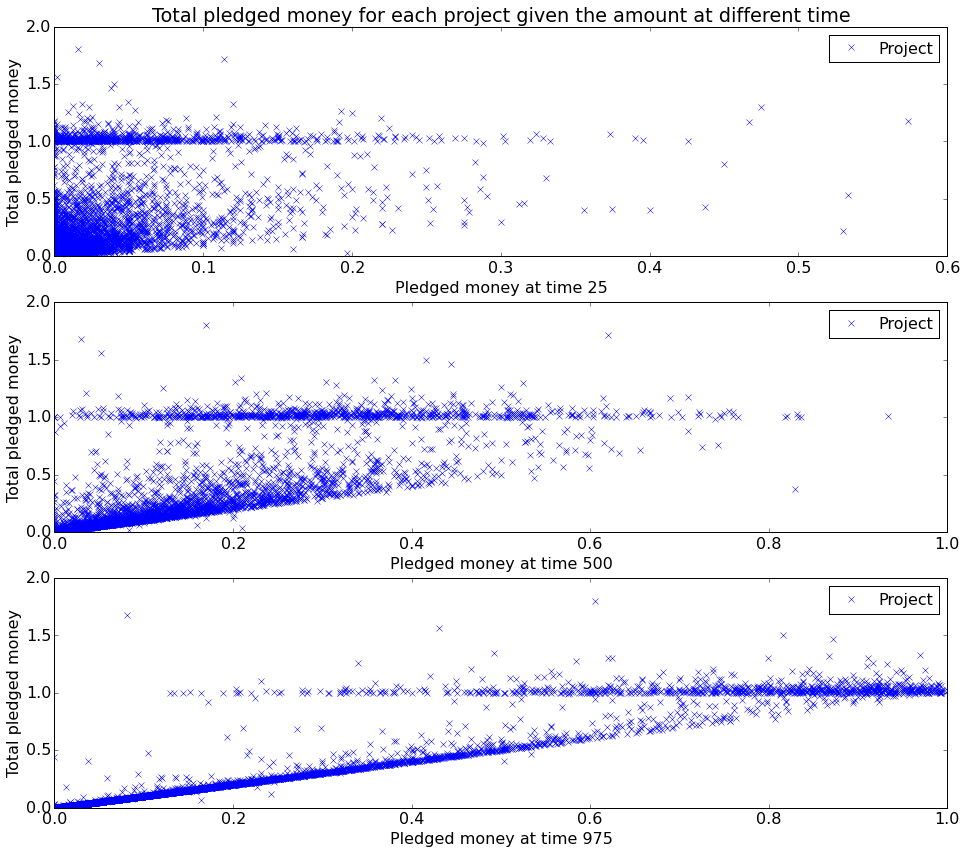

In [114]:
T = 999

plt.figure(2)

plt.subplot(311)
t = 25
yt = [p.money[t] for p in projects_train if p.money[T] < 10 and p.money[t] < 1]
yT = [p.money[T] for p in projects_train if p.money[T] < 10 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=1, numpoints=1)
plt.title('Total pledged money for each project given the amount at different time')

plt.subplot(312)
t = 500
yt = [p.money[t] for p in projects_train if p.money[T] < 10 and p.money[t] < 1]
yT = [p.money[T] for p in projects_train if p.money[T] < 10 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=1, numpoints=1)

plt.subplot(313)
t = 975
yt = [p.money[t] for p in projects_train if p.money[T] < 10 and p.money[t] < 1]
yT = [p.money[T] for p in projects_train if p.money[T] < 10 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=1, numpoints=1)


plt.savefig('final_money_vs_pledged_money_fixed.pdf')
plt.show()

## Training

### Grid Search Training

In [ ]:
K = 3
epsilon = 1e-2
iterations = 1000
random_restarts = 10
betas = np.array([1/np.var(y_train)])
lambdas = np.logspace(-8, 2, 50)
lambdas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
k_fold = 2

mls = LeastSquaresMixture(X_train, y_train, K=K,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
rmse_avg, rmse_std, accuracy_avg, accuracy_std = mls.grid_search(betas, lambdas, k_fold=k_fold)

print(mls)

### Simple Training

In [4]:
K = 2
beta = 1 / np.var(y_train)
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls1 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls1.train(verbose=False)

print(mls1)

Model:        LeastSquaresMixture (2 components)
Likelihood:   -11252.2004486247
Beta:         2.5517286094421414
Lambda:       0
Pi:           [ 0.25673757  0.74326243]
Weights norm: [8.9713035868699631, 2.6626544374705001]
[[ 0.32275271  0.44241514]
 [ 8.96549601  2.6256423 ]]


In [6]:
K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls2 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls2.train(verbose=False)

print(mls2)

Model:        LeastSquaresMixture (2 components)
Likelihood:   -4540.656090008966
Beta:         8.97175717903968
Lambda:       0
Pi:           [ 0.71747013  0.28252987]
Weights norm: [1.3084602001217194, 2.0965684744728543]
[[ 0.15246969  0.13868828]
 [ 1.29954649  2.09197632]]


In [16]:
K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0.01
iterations = 1000
random_restarts = None

mls3 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls3.train(verbose=True)

print(mls3)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = 0.969166112376
* Lambda = 0.01
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1.0
Obj	pi1	pi2	w11	w12	w21	w22	beta
-11327.63		0.49	0.51	0.01	1.06	0.01	1.07	5.80
-955.84		0.49	0.51	0.01	1.07	0.01	1.07	63.32
7294.74		0.49	0.51	0.01	1.05	0.00	1.08	63.50
7422.54		0.50	0.50	0.02	1.04	-0.01	1.10	65.89
7612.88		0.51	0.49	0.02	1.03	-0.01	1.11	69.67
7680.63		0.52	0.48	0.02	1.03	-0.01	1.12	71.40
7714.23		0.54	0.46	0.02	1.03	-0.01	1.12	72.45
7743.07		0.56	0.44	0.02	1.03	-0.01	1.12	73.36
7772.26		0.58	0.42	0.01	1.03	-0.00	1.13	74.27
7803.76		0.60	0.40	0.01	1.03	-0.00	1.13	75.25
7839.05		0.62	0.38	0.01	1.03	0.00	1.13	76.36
7879.90		0.64	0.36	0.01	1.04	0.00	1.14	77.67
7928.70		0.67	0.33	0.01	1.04	0.01	1.14	79.30
7988.08		0.69	0.31	0.01	1.04	0.01	1.15	81.38
8062.11		0.72	0.28	0.00	1.04	0.02	1.15	84.11
8158.72		0.75	0.25	0.00	1.04	0.03	1.16	87.78
8290.08		0.78	0.22	0.00	1.04	0.04	1.17	92.

In [17]:
x = np.ones((1000, 2))
x[:, 1] = np.linspace(0, 1, 1000)

w11 = mls1.w[:, 0]
w12 = mls1.w[:, 1]
y11 = x.dot(w11)
y12 = x.dot(w12)

w21 = mls2.w[:, 0]
w22 = mls2.w[:, 1]
y21 = x.dot(w21)
y22 = x.dot(w22)

w31 = mls3.w[:, 0]
w32 = mls3.w[:, 1]
y31 = x.dot(w31)
y32 = x.dot(w32)

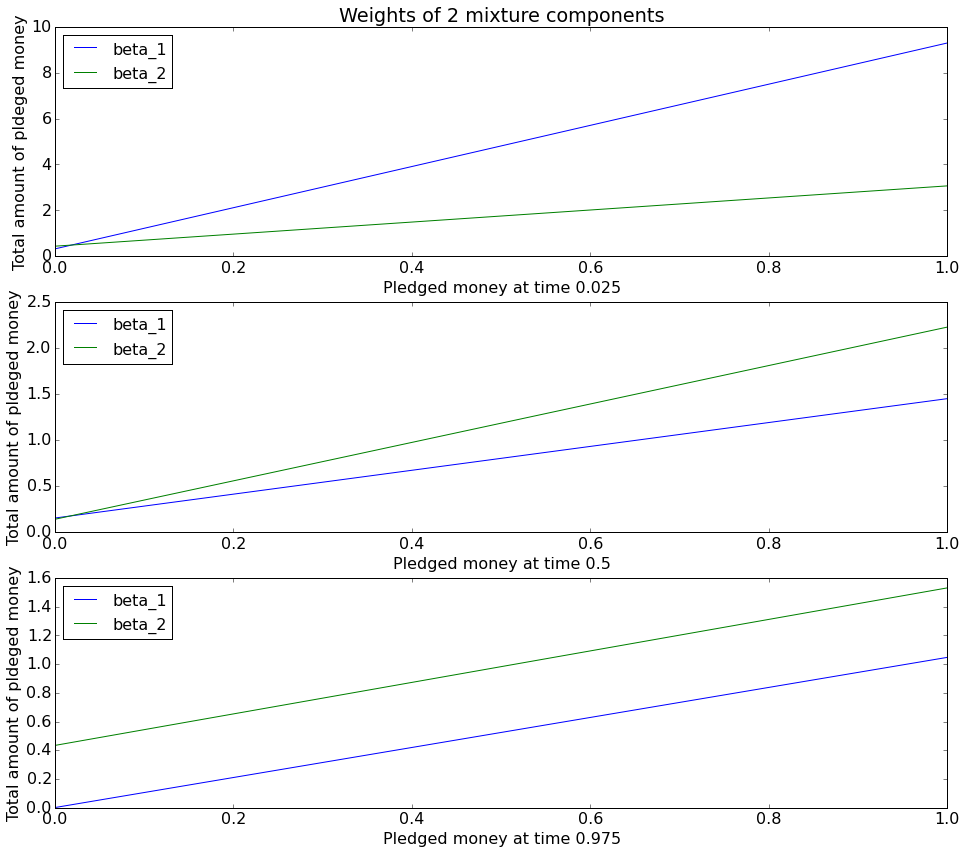

In [18]:
plt.figure(1)

plt.subplot(311)
plt.plot(x[:, 1], y11)
plt.plot(x[:, 1], y12)
plt.title("Weights of 2 mixture components")
plt.xlabel("Pledged money at time 0.025")
plt.ylabel("Total amount of pldeged money")
plt.legend(["beta_1", "beta_2"], loc=2)

plt.subplot(312)
plt.plot(x[:, 1], y21)
plt.plot(x[:, 1], y22)
plt.xlabel("Pledged money at time 0.5")
plt.ylabel("Total amount of pldeged money")
plt.legend(["beta_1", "beta_2"], loc=2)

plt.subplot(313)
plt.plot(x[:, 1], y31)
plt.plot(x[:, 1], y32)
plt.xlabel("Pledged money at time 0.975")
plt.ylabel("Total amount of pldeged money")
plt.legend(["beta_1", "beta_2"], loc=2)


plt.savefig("weights.pdf")
plt.show()

## Testing

### Full Test Set

In [12]:
rmse, accuracy = mls2.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (4813/4813): [####################] 100% Elapsed time: 0:00:03
Accuracy: 0.9690421774361105
RMSE    : 119.666166047


### Single Point

In [30]:
test = 8
x_new = X_test[test]
y_new = mls3.predict(x_new, posteriors=True)
print("Predicted:  %s" % y_new)
#print("Posteriors: %s" % ["%0.2f%%" % (p * 100) for p in y_posteriors])
print("Actual:     %s" % y_test[test])

Predicted:  1.97146123459
Actual:     [ 1.47129687]


## Plots

### 0-1 Loss

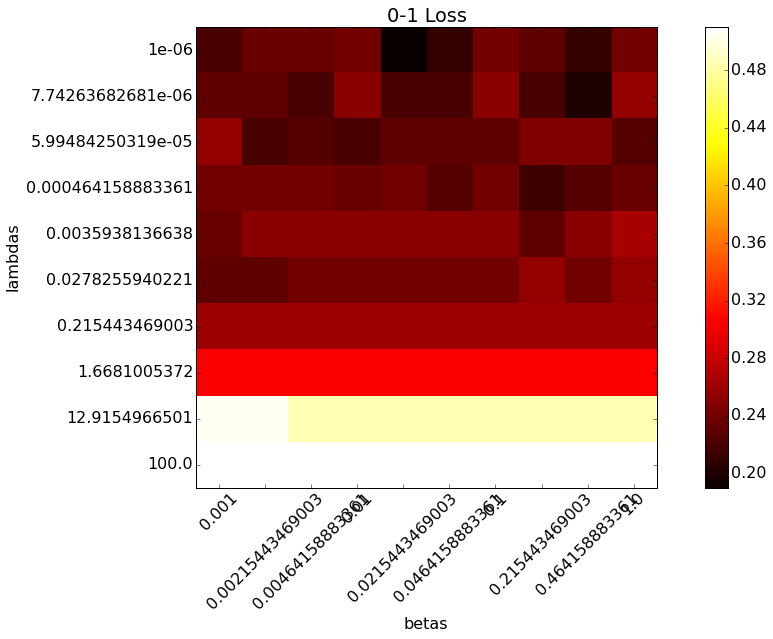

In [19]:
with open("accuracy_all_gridsearch.pkl", 'rb') as f:
    accuracy_avg = cp.load(f)
betas = np.logspace(-3, 0, 10)
lambdas = np.logspace(-6, 2, 10)

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(1 - np.array(accuracy_avg), interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.colorbar()
plt.xticks(np.arange(len(betas)), ["%s" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.title('0-1 Loss')
plt.show()

In [21]:
with open("accuracy_all.pkl", 'rb') as f:
    accuracy_avg = cp.load(f)
    
lambdas = np.logspace(-6, 2, 10)
plt.errorbar(list(lambdas), [1-a[0] for a in accuracy_avg], yerr=[a[0] for a in accuracy_std])
plt.xscale('log')
plt.title("0-1 Loss (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("0-1 Loss")
plt.show()

NameError: name 'accuracy_std' is not defined

### RMSE

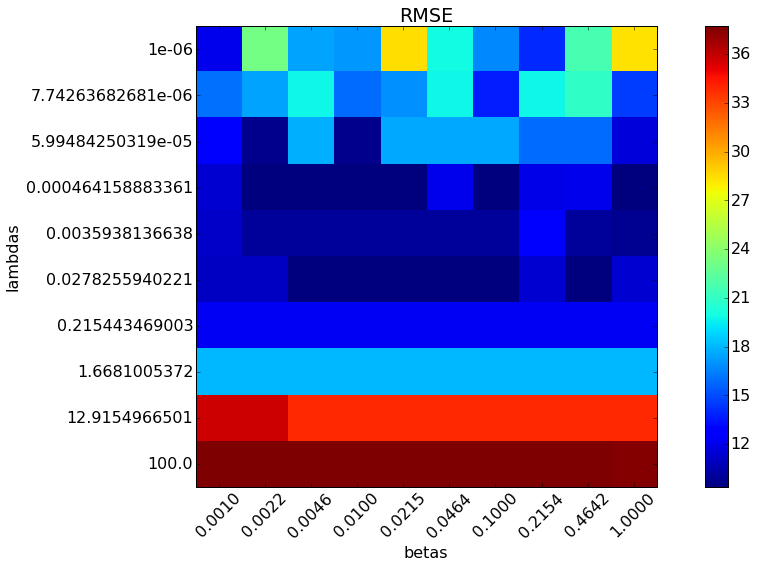

In [26]:
with open("rmse_all_gridsearch.pkl", 'rb') as f:
    rmse_avg = cp.load(f)
betas = np.logspace(-3, 0, 10)
lambdas = np.logspace(-6, 2, 10)

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(rmse_avg, interpolation='nearest')
plt.xticks(np.arange(len(betas)), ["%0.4f" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.colorbar()
plt.title('RMSE')
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.show()

In [ ]:
plt.errorbar(list(lambdas), [r[0] for r in rmse_avg], yerr=[r[0] for r in rmse_std])
plt.xscale('log')
plt.title("RMSE (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("RMSE")
plt.show()